# Clustering de documents

## Imports

In [2]:
import collections
import os
import string
import sys

import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
from pprint import pprint
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

In [3]:
import nltk

nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [Errno 104] Connection
[nltk_data]     reset by peer>


False

In [5]:
data_path = "../data/txt/"

## Choisir une décennie

In [6]:
year = '1880'

## Charger tous les  fichiers de la décennie et en créer une liste de textes

In [7]:
files = [f for f in os.listdir(data_path) if os.path.isfile(os.path.join(data_path, f)) and str(year) in f and "RptAn" in f]

In [8]:
# Exemple de fichiers
files[:5]

['Lkn_1880_Tome_RptAn_Part_1.txt',
 'Lkn_1880_Tome_RptAn_Part_2.txt',
 'Lkn_1880_Tome_RptAn_Part_3.txt',
 'Lkn_1880_Tome_RptAn_Part_4.txt',
 'Lkn_1880_Tome_RptAn_Part_5.txt']

In [9]:
texts = [open(data_path + f).read() for f in files]

In [10]:
# Exemple de textes
texts[0][:400]

"\x0cCOMMUNE DE L A E K E N .\n\nCOMPTE\n\nCOMMUNAL\n\nPOUR L'EXERCICE DE 1872.\n\nRapport\n\ndes sections réunies\n\nau Conseil\n\ncommunal.\n\nMESSIEURS,\n\nLes Sections réunies, auxquelles vous avez renvoyé le Compte communal de 1872 pour examen, ont, en séances des 18 et 25 juillet\net 1 , 8 et 14 août, examiné, article par article, les recettes et dépenses ; elles m'ont chargé de vous présenter, Messieurs, les obse"

## Vectoriser les documents à l'aide de TF-IDF

In [11]:
# Création d'une fonction de pré-traitement
def preprocessing(text, stem=True):
    """ Tokenize text and remove punctuation """
    text = text.translate(string.punctuation)
    tokens = word_tokenize(text)
    return tokens

### Instancier le modèle TF-IDF avec ses arguments

In [12]:
vectorizer = TfidfVectorizer(
    tokenizer=preprocessing,
    stop_words=stopwords.words('french'),
    max_df=0.5,
    min_df=0.1,
    lowercase=True)

### Construire la matrice de vecteurs à l'aide de la fonction `fit_transform`

In [13]:
%time tfidf_vectors = vectorizer.fit_transform(texts)

CPU times: user 3.83 s, sys: 0 ns, total: 3.83 s
Wall time: 4.04 s


In [14]:
# Détail de la matrice
tfidf_vectors

<5x23164 sparse matrix of type '<class 'numpy.float64'>'
	with 25989 stored elements in Compressed Sparse Row format>

### Imprimer le vecteur tf-IDF du premier document

In [15]:
pd.Series(
    tfidf_vectors[0].toarray()[0],
    index=vectorizer.get_feature_names_out()
    ).sort_values(ascending=False)

proposent           0.193587
l'institutrice      0.145190
article             0.126900
l'instituteur       0.097615
recette             0.087854
                      ...   
de+31               0.000000
de+227+191+celui    0.000000
de+220+bruxelles    0.000000
de+2,722            0.000000
••                  0.000000
Length: 23164, dtype: float64

## Comprendre les vecteurs et leurs "distances"

In [16]:
cosine([1, 2, 3], [1, 2, 3])

0

In [17]:
cosine([1, 2, 3], [1, 2, 2])

0.02004211298777725

In [18]:
cosine([1, 2, 3], [2, 2, 2])

0.07417990022744858

### Tests sur nos documents

In [19]:
tfidf_array = tfidf_vectors.toarray()

In [20]:
# Vecteur du document 0
tfidf_array[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [21]:
# Vecteur du document 1
tfidf_array[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [22]:
cosine(tfidf_array[0], tfidf_array[1])

0.9888994635481292

## Appliquer un algorithme de clustering sur les vecteurs TF-IDF des documents

Pour en savoir plus sur le KMeans clustering :
- https://medium.com/dataseries/k-means-clustering-explained-visually-in-5-minutes-b900cc69d175

### Définir un nombre de clusters

In [23]:
N_CLUSTERS = 4

### Instancier le modèle K-Means et ses arguments

In [24]:
km_model = KMeans(n_clusters=N_CLUSTERS)

### Appliquer le clustering à l'aide de la fonction `fit_predict`

In [25]:
clusters = km_model.fit_predict(tfidf_vectors)

In [26]:
clustering = collections.defaultdict(list)

for idx, label in enumerate(clusters):
    clustering[label].append(files[idx])

In [27]:
pprint(dict(clustering))

{0: ['Lkn_1880_Tome_RptAn_Part_1.txt'],
 1: ['Lkn_1880_Tome_RptAn_Part_2.txt', 'Lkn_1880_Tome_RptAn_Part_3.txt'],
 2: ['Lkn_1880_Tome_RptAn_Part_4.txt'],
 3: ['Lkn_1880_Tome_RptAn_Part_5.txt']}


## Visualiser les clusters

### Réduire les vecteurs à 2 dimensions à l'aide de l'algorithme PCA
Cette étape est nécessaire afin de visualiser les documents dans un espace 2D

https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales

In [28]:
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(tfidf_vectors.toarray())

In [29]:
reduced_vectors[:10]

array([[-0.38150235,  0.7953639 ],
       [ 0.65376564,  0.00222879],
       [ 0.60605282, -0.03681694],
       [-0.40596693, -0.52819382],
       [-0.47234917, -0.23258193]])

### Générer le plot

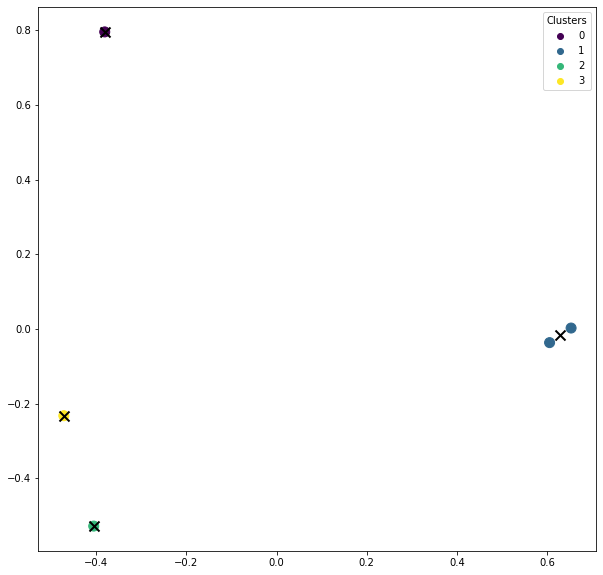

In [30]:
x_axis = reduced_vectors[:, 0]
y_axis = reduced_vectors[:, 1]

plt.figure(figsize=(10,10))
scatter = plt.scatter(x_axis, y_axis, s=100, c=clusters)

# Ajouter les centroïdes
centroids = pca.transform(km_model.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1],  marker = "x", s=100, linewidths = 2, color='black')

# Ajouter la légende
plt.legend(handles=scatter.legend_elements()[0], labels=set(clusters), title="Clusters")